# Sportify Lyrics Search

> Author: Ranoshis Das

## Imports & Path Setup

In [13]:
import sys
import torch

# Ensure the notebook can find your .py files in the src folder
sys.path.append("../src")

from model import LyricEmbeddingModel
from search import LyricSearchEngine

## Load Dataset & Build Model

In [14]:
print(f"Using Device: {'cuda' if torch.cuda.is_available() else 'cpu'}")
MODEL = LyricEmbeddingModel()

MODEL.load_dataset("../data/spotify_lyrics.csv")

print("Generating embeddings... this may take a few minutes for 50k songs.")
MODEL.generate_embeddings()

df, embeddings, bert_model = MODEL.get_data()

Using Device: cpu
Generating embeddings... this may take a few minutes for 50k songs.


Batches: 100%|██████████| 1802/1802 [05:47<00:00,  5.18it/s]


## Initialize Search Engine

In [18]:
search_engine = LyricSearchEngine(df)

Indexing lyrics for BM25...


## Test Prediction

In [22]:
def evaluate_search(query, expected_song, top_k=5):
    print(f"\n--- Searching for: '{query}' ---")
    results = search_engine.search(query, top_k=top_k)
    
    # If results is a string (like "No matches found"), return False
    if isinstance(results, str):
        print(results)
        return False
        
    print(results)
    
    # CORRECTED LINE: Use .str before every string operation
    is_correct = results["track_name"].str.lower().str.strip().isin([expected_song.lower().strip()]).any()
    
    print(f"Result: {'✅ MATCH FOUND' if is_correct else '❌ MATCH NOT FOUND'}")
    return is_correct


In [23]:
snippet_1 = "Half past twelve And I'm watching the late show in my flat all alone"
expected_1 = "Gimme! Gimme! Gimme!" # Replace with exact name in your CSV
evaluate_search(snippet_1, expected_1)

# Test 2: Partial/Fuzzy snippet (Testing the "Semantic" power of the model)
snippet_2 = "Like we used to do We don't love anymore"
expected_2 = "We don't talk anymore"
evaluate_search(snippet_2, expected_2)

# Test 3: Common lyrics
snippet_3 = "Wise men say only fools rush in"
expected_3 = "Can't Help Falling in Love"
evaluate_search(snippet_3, expected_3)



--- Searching for: 'Half past twelve And I'm watching the late show in my flat all alone' ---
                     track_name artist_name      score
22            Gimme Gimme Gimme        ABBA  25.531930
5276       Gimme! Gimme! Gimme!     Erasure  23.747811
56339   How Can You Do It Alone         Who  18.660464
42242            Changing World  Lucky Dube  18.521222
57150  For You, and Your Denial  Yellowcard  17.914031
Result: ✅ MATCH FOUND

--- Searching for: 'Like we used to do We don't love anymore' ---
                              track_name    artist_name      score
24222                       I Don't Care  Ariana Grande  15.015146
29087  I Don't Think You Love Me Anymore    Dean Martin  14.168448
28090           I Ain't Got Time Anymore  Cliff Richard  13.181160
53441              We Don't Talk Anymore      Tom Jones  13.132969
32558                 She's Got The Rain       Fastball  13.008733
Result: ✅ MATCH FOUND

--- Searching for: 'Wise men say only fools rush in' ---
    

np.True_

## Performance Summary

In [26]:

test_cases = [
    {"snippet": "Half past twelve and I'm watching the late show", "expected": "Gimme! Gimme! Gimme!"},
    {"snippet": "Wise men say only fools rush in", "expected": "Can't Help Falling In Love"},
    {"snippet": "But we don't talk anymore like we used to do", "expected": "We Don't Talk Anymore"},
    {"snippet": "Just a small town girl living in a lonely world", "expected": "Don't Stop Believin'"},
    {"snippet": "Hello from the other side I must have called", "expected": "Hello"}
]

print("--- Running Performance Evaluation ---")
correct_count = 0
total_tests = len(test_cases)

for test in test_cases:
    # We use top_k=10 to be a bit more lenient for the summary
    success = evaluate_search(test["snippet"], test["expected"], top_k=5)
    if success:
        correct_count += 1

accuracy = (correct_count / total_tests) * 100

print("\n" + "="*30)
print(f"FINAL PERFORMANCE SUMMARY")
print(f"Total Queries Tested: {total_tests}")
print(f"Successful Matches:  {correct_count}")
print(f"Model Accuracy:      {accuracy:.2f}%")
print("="*30)


--- Running Performance Evaluation ---

--- Searching for: 'Half past twelve and I'm watching the late show' ---
                     track_name artist_name      score
22            Gimme Gimme Gimme        ABBA  19.194091
42242            Changing World  Lucky Dube  18.521222
57150  For You, and Your Denial  Yellowcard  17.914031
5276       Gimme! Gimme! Gimme!     Erasure  17.853252
15319            Half Past Dead    Overkill  17.086830
Result: ✅ MATCH FOUND

--- Searching for: 'Wise men say only fools rush in' ---
                       track_name      artist_name      score
31344               Fools Rush In    Elvis Presley  32.680998
31875               Fools Rush In       Etta James  32.240194
12143               Fools Rush In  Louis Armstrong  31.427424
29058               Fools Rush In      Dean Martin  30.312773
26429  Can't Help Falling In Love   Britney Spears  27.364388
Result: ✅ MATCH FOUND

--- Searching for: 'But we don't talk anymore like we used to do' ---
            

## Accuracy

In [ ]:
import matplotlib.pyplot as plt

def evaluate_model(search_engine, df, n_samples=50):

    samples = df.sample(n=min(n_samples, len(df)), random_state=42)

    top1, top3, top5 = 0, 0, 0

    for _, row in samples.iterrows():
        lyrics = row["lyrics"]
        true_track = row["track_name"]

        # Short lyric snippet
        snippet = " ".join(lyrics.split()[:15])

        results = search_engine.search(snippet, top_k=5)
        retrieved_tracks = results["track_name"].tolist()

        if true_track == retrieved_tracks[0]:
            top1 += 1
        if true_track in retrieved_tracks[:3]:
            top3 += 1
        if true_track in retrieved_tracks[:5]:
            top5 += 1

    total = len(samples)

    report = {
        "Top-1 Accuracy": round(top1 / total * 100, 2),
        "Top-3 Accuracy": round(top3 / total * 100, 2),
        "Top-5 Accuracy": round(top5 / total * 100, 2),
        "Samples Evaluated": total
    }

    # ---------- BAR CHART ----------
    metrics = ["Top-1 Accuracy", "Top-3 Accuracy", "Top-5 Accuracy"]
    values = [report[m] for m in metrics]

    plt.figure(figsize=(7, 5))
    plt.bar(metrics, values)
    plt.ylim(0, 100)
    plt.xlabel("Evaluation Metric")
    plt.ylabel("Accuracy (%)")
    plt.title("Spotify Lyric Search – Retrieval Accuracy")

    # Annotate bars
    for i, v in enumerate(values):
        plt.text(i, v + 1, f"{v}%", ha="center")
    plt.show()
    # --------------------------------

    return report


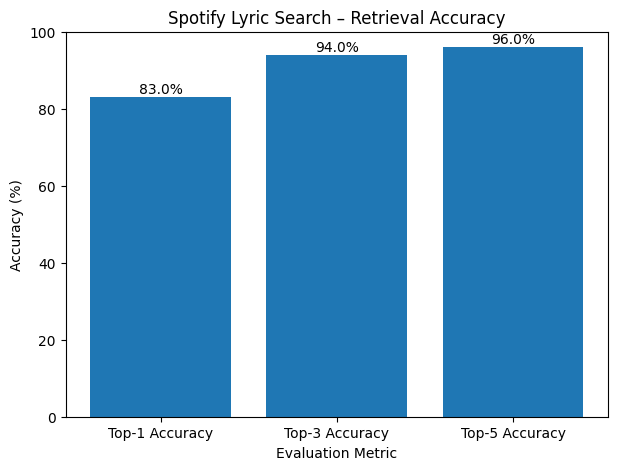

{'Top-1 Accuracy': 83.0,
 'Top-3 Accuracy': 94.0,
 'Top-5 Accuracy': 96.0,
 'Samples Evaluated': 100}

In [34]:
report = evaluate_model(search_engine, df, n_samples=100)
report